In [15]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

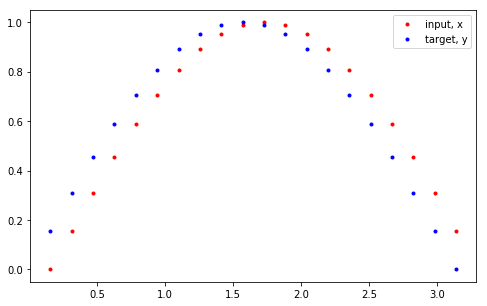

In [2]:
plt.figure(figsize=(8,5))

seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1))

x = data[:-1] 
y = data[1:] 

plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size,output_size,hidden_dim, n_layers):
        super(RNN,self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self,x,hidden):
        
        batch_size =x.size(0)
        
        r_out, hidden = self.rnn(x,hidden)
        r_out = r_out.view(-1,self.hidden_dim)
        
        output = self.fc(r_out)
        
        return output, hidden

In [26]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [28]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

rnn = RNN(input_size,output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.01)

In [32]:
def train(rnn, n_steps, print_every):
    
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.4439293444156647


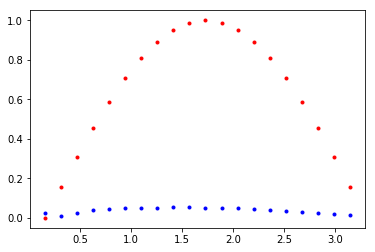

Loss:  0.006766205653548241


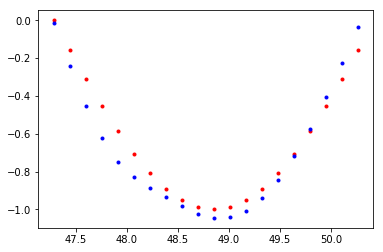

Loss:  0.0023503268603235483


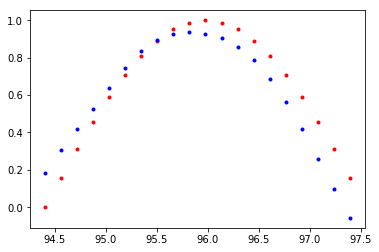

Loss:  0.0005972326616756618


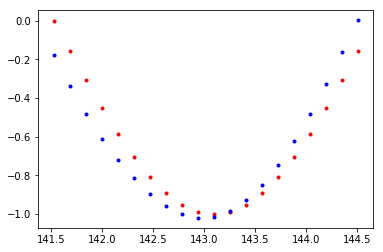

Loss:  0.00032704666955396533


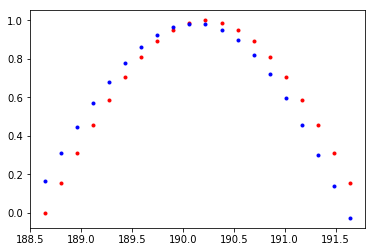

In [33]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)